In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.compose import make_column_transformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import KBinsDiscretizer

from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from google.colab import drive

from prettytable import PrettyTable

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


- Data contains various categorical, numerical and text features.

- We have to predict whether the project application will get accepted or not.

- https://www.kaggle.com/c/donorschoose-application-screening

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/6_Donors_choose_NB/preprocessed_data.csv')
data.head(3)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00


In [ ]:
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

### **Set-1:**

<h3>Encoding features using column transformer.</h3>

In [ ]:
transform_set1 = make_column_transformer(
    ( CountVectorizer(max_df=0.85,stop_words='english') , 'essay' ),  #BoW on essay
    ( OneHotEncoder(handle_unknown='ignore') , (0, 1, 2, 4, 5) ),     #One Hot encoding on categorical features
    ( KBinsDiscretizer(n_bins=4,strategy='quantile') , [3,7] )        #categorizing numerical features based on quantile(have tried bining instead of normalizing)
    )

In [ ]:
a=transform_set1.fit_transform(X_train,y_train)
print('No. of Features:',len(a[0].toarray()[0]))

No. of Features: 48308


<h3>Doing Grid-Search over various alpha values.</h3>

In [ ]:
pipe_set1 = make_pipeline( transform_set1 , MultinomialNB() )

pipe_set1.get_params().keys()

In [ ]:
params = {'multinomialnb__alpha':[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}
                    
clf_set1 = GridSearchCV( pipe_set1, params, cv=3, scoring='roc_auc', return_train_score=True, refit=False) 
clf_set1.fit(X_train,y_train)

cv_set_1 = pd.DataFrame(clf_set1.cv_results_)

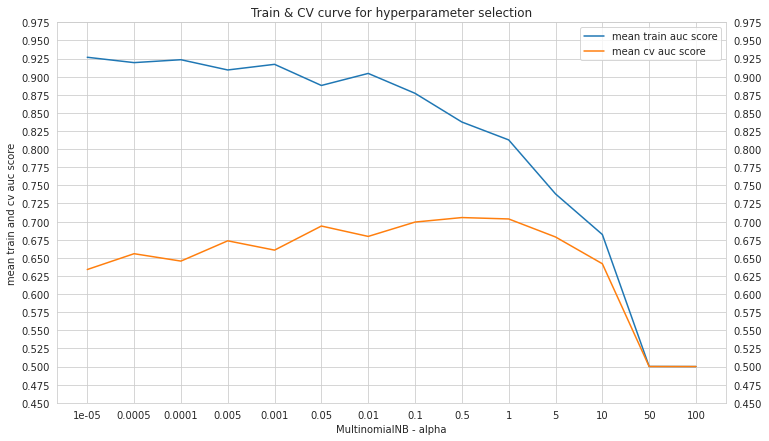

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(12,7))
sns.lineplot(np.arange(len(params['multinomialnb__alpha'])), y=cv_set_1.mean_train_score, label='mean train auc score')
sns.lineplot(np.arange(len(params['multinomialnb__alpha'])), y=cv_set_1.mean_test_score, label='mean cv auc score')
plt.xticks(np.arange(len(params['multinomialnb__alpha'])), labels=params['multinomialnb__alpha'])
plt.yticks(np.arange(0.45,1,0.025))
plt.tick_params(labelright=True)
plt.xlabel('MultinomialNB - alpha')
plt.ylabel('mean train and cv auc score')
plt.title('Train & CV curve for hyperparameter selection')
plt.legend()
plt.show()

**Observation:**

- alpha = 5 and alpha = 10 both seems reasonable.

<h3>Again doing Grid search with alpha=[5,10] and various values of max_features</h3>

In [ ]:
params = {'multinomialnb__alpha':[5,10],
          'columntransformer__countvectorizer__max_features':[1000,2500,5000,7500,10000]}
                      
clf_set1 = GridSearchCV( pipe_set1, params, cv=3, scoring='roc_auc', return_train_score=True, refit=False) 
clf_set1.fit(X_train,y_train)

cv_set_1 = pd.DataFrame(clf_set1.cv_results_)

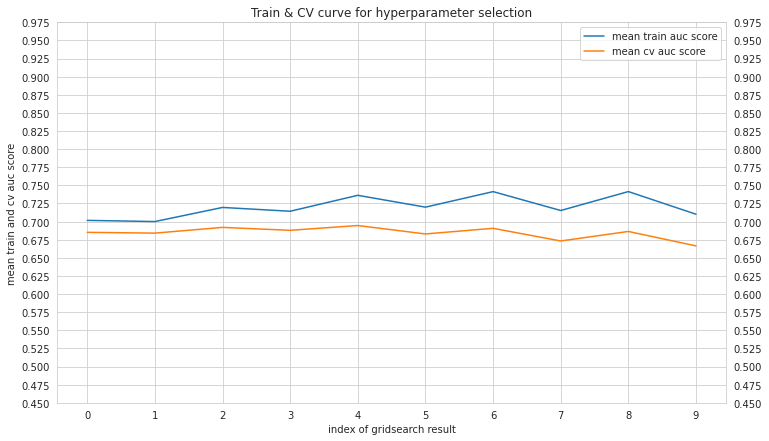

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(12,7))
sns.lineplot(np.arange(10), y=cv_set_1.mean_train_score, label='mean train auc score')
sns.lineplot(np.arange(10), y=cv_set_1.mean_test_score, label='mean cv auc score')
plt.xticks(np.arange(10))
plt.yticks(np.arange(0.45,1,0.025))
plt.tick_params(labelright=True)
plt.xlabel('index of gridsearch result')
plt.ylabel('mean train and cv auc score')
plt.title('Train & CV curve for hyperparameter selection')
plt.legend()
plt.show()

**Observation:**

   Index no. 2 seems reasonable. getting hyperparameter value below.

In [ ]:
cv_set_1.iloc[2,[4,5,10,16]]

param_columntransformer__countvectorizer__max_features        2500
param_multinomialnb__alpha                                       5
mean_test_score                                           0.692022
mean_train_score                                          0.719535
Name: 2, dtype: object

**Observation:**

We get,

max_features = 2500

alpha = 5


<h3>Training on whole X_train.</h3>

In [ ]:
param={'multinomialnb__alpha':5,
   'multinomialnb__class_prior':None,
   'columntransformer__countvectorizer__max_features':2500}

pipe_set1.set_params(**param)
pipe_set1.fit(X_train,y_train)
y_predict_test = pipe_set1.predict_proba(X_test)[:,1]
y_predict_train = pipe_set1.predict_proba(X_train)[:,1]
auc_score_set1_test = roc_auc_score(y_test, y_predict_test )
auc_score_set1_train = roc_auc_score(y_train, y_predict_train )
print('Test AUC Score:', auc_score_set1_test )
print('Train AUC Score:', auc_score_set1_train)

Test AUC Score: 0.70131306385036
Train AUC Score: 0.7128906734395434


In [ ]:
confusion_matrix_train_set1 = confusion_matrix(y_train,pipe_set1.predict(X_train),normalize='true')
confusion_matrix_train_set1 

array([[0.53018136, 0.46981864],
       [0.23011286, 0.76988714]])

In [ ]:
confusion_matrix_test_set1 = confusion_matrix(y_test,pipe_set1.predict(X_test),normalize='true')
confusion_matrix_test_set1 

array([[0.51767723, 0.48232277],
       [0.23171967, 0.76828033]])

<h3>Trying class prior = [50,50]</h3>

In [ ]:
param={'multinomialnb__alpha':5,
   'multinomialnb__class_prior':[50,50],
   'columntransformer__countvectorizer__max_features':2500}

pipe_set1.set_params(**param)
pipe_set1.fit(X_train,y_train)
y_predict_test = pipe_set1.predict_proba(X_test)[:,1]
y_predict_train = pipe_set1.predict_proba(X_train)[:,1]

In [ ]:
auc_score_set1_test = roc_auc_score(y_test, y_predict_test )
auc_score_set1_train = roc_auc_score(y_train, y_predict_train )
print('Test AUC Score:', auc_score_set1_test )
print('\nTrain AUC Score:', auc_score_set1_train)

confusion_matrix_train_set1 = confusion_matrix(y_train,pipe_set1.predict(X_train),normalize='true')
print('\nTrain Confusion Matrix:\n\n',confusion_matrix_train_set1)
confusion_matrix_test_set1 = confusion_matrix(y_test,pipe_set1.predict(X_test),normalize='true')
print('\nTest Confusion Matrix:\n\n',confusion_matrix_test_set1)

Test AUC Score: 0.7013130698381262

Train AUC Score: 0.7128906807027795

Train Confusion Matrix:

 [[0.6716593 0.3283407]
 [0.3521324 0.6478676]]

Test Confusion Matrix:

 [[0.6644074 0.3355926]
 [0.3538718 0.6461282]]


**Observation:**

- By using class prior of [50,50] we get no change in auc score but we get good balance between FP & TP.
- So, we continue using class prior of [50,50].

**Note:**

- With change in class prior we can tradeoff between TP & FP as per requirement.

- We want our model to have high TP and low FP, so now we threshold probability at max. value of TPR(1-FPR).

<h3>Finding optimal probability threshold</h3>

In [ ]:
fpr_train, tpr_train, thresholds = roc_curve( y_train,  y_predict_train )

In [ ]:
fpr_test, tpr_test ,threshold_test = roc_curve( y_test ,  y_predict_test )

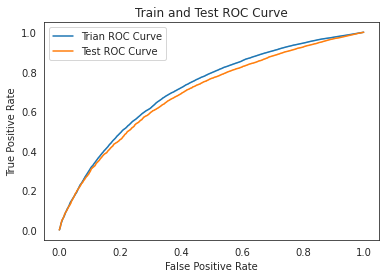

In [ ]:
sns.lineplot(fpr_train , tpr_train , label='Trian ROC Curve')
sns.lineplot(fpr_test , tpr_test , label='Test ROC Curve')
plt.title('Train and Test ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Train AUC Score: 0.71

Test AUC Score: 0.70

In [ ]:
threshold =  thresholds[np.argmax(tpr_train*(1-fpr_train))]

y_train_after_thresholding = np.copy(y_predict_train)
y_train_after_thresholding = np.where( y_train_after_thresholding > threshold , 1, 0)
confusion_matrix_train_set1_thresh = confusion_matrix(y_train,y_train_after_thresholding,normalize='true')
print('Train Confusion Matrix after thresholding probability:\n',confusion_matrix_train_set1_thresh)

y_test_after_thresholding = np.copy(y_predict_test)
y_test_after_thresholding = np.where( y_test_after_thresholding > threshold , 1, 0)
confusion_matrix_test_set1_thresh = confusion_matrix(y_test,y_test_after_thresholding,normalize='true')
print('\nTest Confusion Matrix after thresholding probability:\n',confusion_matrix_test_set1_thresh)

Train Confusion Matrix after thresholding probability:
 [[0.6764414  0.3235586 ]
 [0.35585143 0.64414857]]

Test Confusion Matrix after thresholding probability:
 [[0.66660561 0.33339439]
 [0.35792502 0.64207498]]


**Observation:**

- After thresholding we see slight chances in TP & FP compared to using class prior [50,50].

- We continue with new threshold.


<h3>Confusion Matrix(normalized) after threshold</h3>

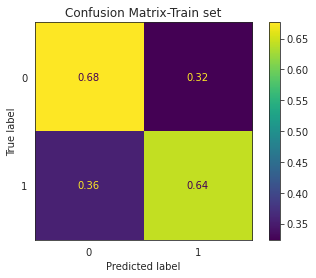

In [ ]:
sns.set_style('white')
ConfusionMatrixDisplay.from_predictions(y_train, y_train_after_thresholding, normalize='true')
plt.title('Confusion Matrix-Train set')
plt.show()

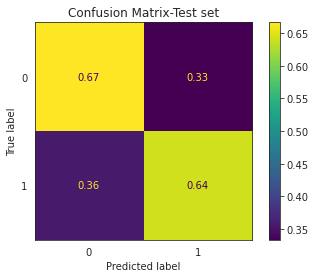

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_after_thresholding, normalize='true') 
plt.title('Confusion Matrix-Test set')
plt.show()

<h3>Getting Top 50 Features:</h3>

In [ ]:
def top_features(clf,n):
  features = clf.named_steps.columntransformer.get_feature_names_out()
  prob = clf.named_steps.multinomialnb.feature_log_prob_
  prob_0 = prob[0,:]
  prob_1 = prob[1,:]
  sort_index_prob_0 = np.argsort(prob_0)[::-1] # https://stackoverflow.com/questions/6771428/most-efficient-way-to-reverse-a-numpy-array
  sort_index_prob_1 = np.argsort(prob_1)[::-1]
  return features[sort_index_prob_0][:n] , features[sort_index_prob_1][:n]


In [ ]:
top_50_features_0 , top_50_features_1 = top_features(pipe_set1,50)
print('top 50 features for predicting class 0:\n', top_50_features_0,'\n' )
print('top 50 features for predicting class 1:\n', top_50_features_1 )

top 50 features for predicting class 0:
 ['countvectorizer__learning' 'countvectorizer__classroom'
 'countvectorizer__learn' 'countvectorizer__help' 'countvectorizer__need'
 'countvectorizer__work' 'countvectorizer__come' 'countvectorizer__love'
 'countvectorizer__reading' 'countvectorizer__able'
 'countvectorizer__materials' 'countvectorizer__skills'
 'countvectorizer__day' 'countvectorizer__use' 'countvectorizer__class'
 'countvectorizer__year' 'countvectorizer__want' 'countvectorizer__make'
 'countvectorizer__new' 'countvectorizer__student'
 'countvectorizer__technology' 'onehotencoder__teacher_prefix_mrs'
 'kbinsdiscretizer__teacher_number_of_previously_posted_projects_0.0'
 'countvectorizer__time' 'countvectorizer__math' 'countvectorizer__grade'
 'countvectorizer__children' 'countvectorizer__provide'
 'onehotencoder__project_grade_category_grades_prek_2'
 'countvectorizer__project' 'countvectorizer__different'
 'countvectorizer__supplies' 'countvectorizer__world'
 'countvectorizer

**Observation:**

- Most of the top features are from Countvectorizer.
- Most of them are same for both classes.

## **Set-2:**

<h3>Encoding features using column transformer</h3>

In [ ]:
transform_set2 = make_column_transformer(
    ( TfidfVectorizer(max_df=0.85,stop_words='english') , 'essay' ),
    ( OneHotEncoder(handle_unknown='ignore') , (0, 1, 2, 4, 5) ),
    ( KBinsDiscretizer(n_bins=4,strategy='quantile') , [3,7] )
    )

In [ ]:
a=transform_set2.fit_transform(X_train,y_train)
print('No. of features:',len(a[0].toarray()[0]))

No. of features: 48308


<h3>Doing Grid-search with various values of alpha.</h3>

In [ ]:
pipe_set2 = make_pipeline( transform_set2 , MultinomialNB() )

In [ ]:
params = {'multinomialnb__alpha':[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}
                      
clf_set2 = GridSearchCV( pipe_set2, params, cv=3, scoring='roc_auc', return_train_score=True, refit=False) 
clf_set2.fit(X_train,y_train)

cv_set_2 = pd.DataFrame(clf_set2.cv_results_)

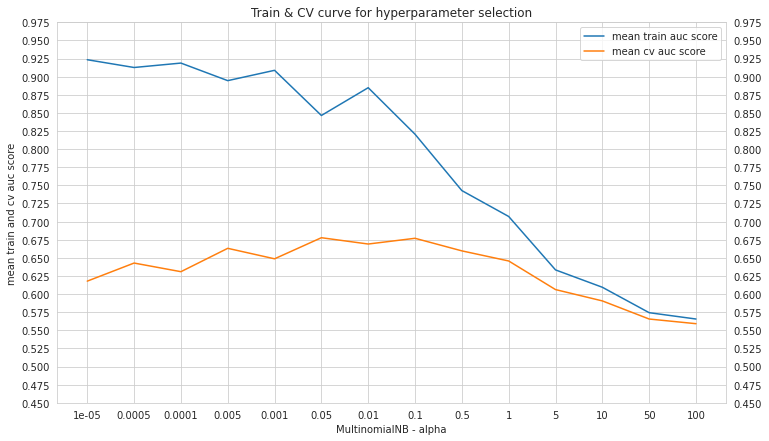

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(12,7))
sns.lineplot(np.arange(len(params['multinomialnb__alpha'])), y=cv_set_2.mean_train_score, label='mean train auc score')
sns.lineplot(np.arange(len(params['multinomialnb__alpha'])), y=cv_set_2.mean_test_score, label='mean cv auc score')
plt.xticks(np.arange(len(params['multinomialnb__alpha'])), labels=params['multinomialnb__alpha'])
plt.yticks(np.arange(0.45,1,0.025))
plt.tick_params(labelright=True)
plt.xlabel('MultinomialNB - alpha')
plt.ylabel('mean train and cv auc score')
plt.title('Train & CV curve for hyperparameter selection')
plt.legend()
plt.show()

**Observation:**

- alpha = 1 and alpha = 5 both seems reasonable.

<h3>Again doing Grid search with alpha=[1,5] and various values of max_features.</h3>

In [ ]:
params = {'multinomialnb__alpha':[1,5],
          'columntransformer__tfidfvectorizer__max_features':[1000,2500,5000,7500,10000]}
                      
clf_set2 = GridSearchCV( pipe_set2, params, cv=3, scoring='roc_auc', return_train_score=True, refit=False) 
clf_set2.fit(X_train,y_train)

cv_set_2 = pd.DataFrame(clf_set2.cv_results_)

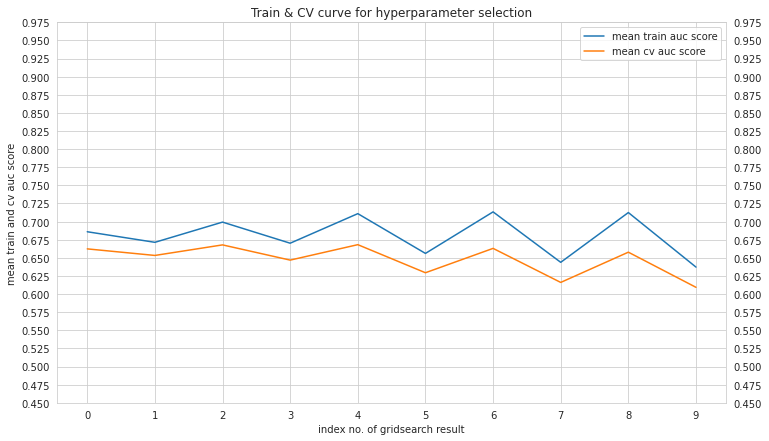

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(12,7))
sns.lineplot(np.arange(10), y=cv_set_2.mean_train_score, label='mean train auc score')
sns.lineplot(np.arange(10), y=cv_set_2.mean_test_score, label='mean cv auc score')
plt.xticks(np.arange(10))
plt.yticks(np.arange(0.45,1,0.025))
plt.tick_params(labelright=True)
plt.xlabel('index no. of gridsearch result')
plt.ylabel('mean train and cv auc score')
plt.title('Train & CV curve for hyperparameter selection')
plt.legend()
plt.show()

**Observation:**

Index no. 2 seems reasonable. getting hyperprmeter value below.

In [ ]:
cv_set_1.iloc[2,[4,5,10,16]]

param_columntransformer__countvectorizer__max_features        2500
param_multinomialnb__alpha                                       5
mean_test_score                                           0.692022
mean_train_score                                          0.719535
Name: 2, dtype: object

**Observation:**

We get,

max_features = 2500

alpha = 5

<h3>Training on whole X_train.</h3>

In [ ]:
param={'multinomialnb__alpha':5,
   'multinomialnb__class_prior':None,
   'columntransformer__tfidfvectorizer__max_features':2500}

pipe_set2.set_params(**param)
pipe_set2.fit(X_train,y_train)
y_predict_test = pipe_set2.predict_proba(X_test)[:,1]
y_predict__train = pipe_set2.predict_proba(X_train)[:,1]
auc_score_set2_test = roc_auc_score(y_test, y_predict_test )
auc_score_set2_train = roc_auc_score(y_train, y_predict_train )
print('Test AUC Score:', auc_score_set2_test )
print('Train AUC Score:', auc_score_set2_train)

Test AUC Score: 0.6634126859462641
Train AUC Score: 0.7128906807027795


In [ ]:
confusion_matrix_train_set2 = confusion_matrix(y_train,pipe_set2.predict(X_train),normalize='true')
confusion_matrix_train_set2

array([[0.02905351, 0.97094649],
       [0.00753465, 0.99246535]])

In [ ]:
confusion_matrix_test_set2 = confusion_matrix(y_test,pipe_set2.predict(X_test),normalize='true')
confusion_matrix_test_set2

array([[0.01868474, 0.98131526],
       [0.00921779, 0.99078221]])

<h3>Trying class prior = [50,50]</h3>

In [ ]:
param={'multinomialnb__alpha':5,
   'multinomialnb__class_prior':[50,50],
   'columntransformer__tfidfvectorizer__max_features':2500}

pipe_set2.set_params(**param)
pipe_set2.fit(X_train,y_train)
y_predict_test = pipe_set2.predict_proba(X_test)[:,1]
y_predict_train = pipe_set2.predict_proba(X_train)[:,1]
auc_score_set2_test = roc_auc_score(y_test, y_predict_test )
auc_score_set2_train = roc_auc_score(y_train, y_predict_train )
print('Test AUC Score:', auc_score_set2_test )
print('Train AUC Score:', auc_score_set2_train)

Test AUC Score: 0.6634126859462641
Train AUC Score: 0.6738478258386486


In [ ]:
confusion_matrix_train_set2 = confusion_matrix(y_train,pipe_set2.predict(X_train),normalize='true')
confusion_matrix_train_set2 

array([[0.55950555, 0.44049445],
       [0.31536071, 0.68463929]])

In [ ]:
confusion_matrix_test_set2 = confusion_matrix(y_test,pipe_set2.predict(X_test),normalize='true')
confusion_matrix_test_set2 

array([[0.54680344, 0.45319656],
       [0.31595463, 0.68404537]])

**Observation:**

- By using class prior of [50,50] we get better fit on data(close train & test auc score) and a significant improvement in overall confusion matrix statistics.

- So, we continue using class prior of [50,50].

- Now we find best threshold using max value of TPR(1-FPR).


<h3>Finding optimal probability threshold</h3>

In [ ]:
fpr_train, tpr_train, thresholds = roc_curve( y_train,  y_predict_train )

In [ ]:
fpr_test, tpr_test ,threshold_test = roc_curve( y_test ,  y_predict_test )

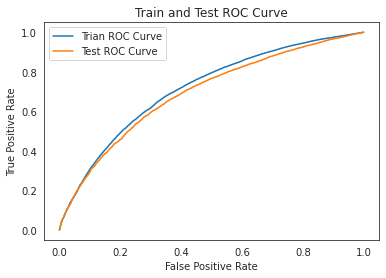

In [ ]:
sns.lineplot(fpr_train , tpr_train , label='Trian ROC Curve')
sns.lineplot(fpr_test , tpr_test , label='Test ROC Curve')
plt.title('Train and Test ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Train AUC Score: 0.67

Test AUC Score: 0.66

In [ ]:
threshold =  thresholds[np.argmax(tpr_train*(1-fpr_train))]

y_train_after_thresholding = np.copy(y_predict_train)
y_train_after_thresholding = np.where( y_train_after_thresholding > threshold , 1, 0)
confusion_matrix_train_set2_thresh = confusion_matrix(y_train,y_train_after_thresholding,normalize='true')
print('Train Confusion Matrix after thresholding probability:\n',confusion_matrix_train_set2_thresh)

y_test_after_thresholding = np.copy(y_predict_test)
y_test_after_thresholding = np.where( y_test_after_thresholding > threshold , 1, 0)
confusion_matrix_test_set2_thresh = confusion_matrix(y_test,y_test_after_thresholding,normalize='true')
print('\nTest Confusion Matrix after thresholding probability:\n',confusion_matrix_test_set2_thresh)

Train Confusion Matrix after thresholding probability:
 [[0.62690607 0.37309393]
 [0.37243411 0.62756589]]

Test Confusion Matrix after thresholding probability:
 [[0.61732918 0.38267082]
 [0.37387638 0.62612362]]


**Observation:**

- We see some change in proportion of TP & FP after probability thresholding.
- So, we continue with new threshold.


<h3>Confusion Matrix(normalized) after threshold</h3>

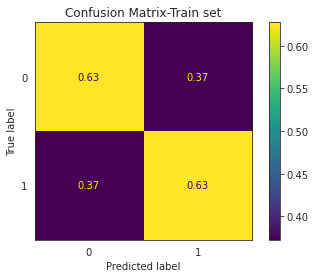

In [ ]:
sns.set_style('white')
ConfusionMatrixDisplay.from_predictions(y_train, y_train_after_thresholding, normalize='true')
plt.title('Confusion Matrix-Train set')
plt.show()

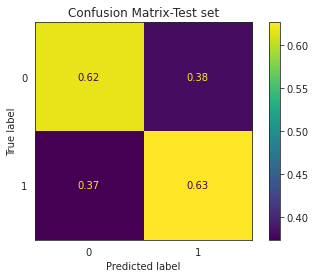

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_after_thresholding, normalize='true') 
plt.title('Confusion Matrix-Test set')
plt.show()

<h3>Getting top 50 features:</h3>

In [ ]:
top_50_features_0 , top_50_features_1 = top_features(pipe_set2,50)
print('top 50 features for predicting class 0:\n', top_50_features_0,'\n' )
print('top 50 features for predicting class 1:\n', top_50_features_1 )

top 50 features for predicting class 0:
 ['onehotencoder__teacher_prefix_mrs'
 'kbinsdiscretizer__teacher_number_of_previously_posted_projects_0.0'
 'onehotencoder__project_grade_category_grades_prek_2'
 'onehotencoder__teacher_prefix_ms'
 'kbinsdiscretizer__teacher_number_of_previously_posted_projects_1.0'
 'kbinsdiscretizer__price_3.0'
 'onehotencoder__project_grade_category_grades_3_5'
 'kbinsdiscretizer__price_2.0' 'kbinsdiscretizer__price_1.0'
 'onehotencoder__clean_categories_literacy_language'
 'onehotencoder__clean_categories_math_science'
 'kbinsdiscretizer__teacher_number_of_previously_posted_projects_2.0'
 'kbinsdiscretizer__price_0.0'
 'onehotencoder__project_grade_category_grades_6_8'
 'onehotencoder__school_state_ca'
 'onehotencoder__clean_categories_literacy_language math_science'
 'onehotencoder__project_grade_category_grades_9_12'
 'onehotencoder__teacher_prefix_mr'
 'onehotencoder__clean_categories_health_sports'
 'onehotencoder__school_state_tx'
 'onehotencoder__clea

**Observation:**

- Most of the top features are categorical( one hot encoded, k-bin discritize).
- Most of them are same for both classes.

Possible reason for difference in top features betweeen both set:
- The most frequent words in essay vocabulary feature may have got high weightage in BoW but got penalize by 'idf' value in tfidf.
- In TfidfVectorizer the final values are l2 or l1 normalize which makes all values <1. so essay feature's value will be less(<1) compared to one hot encoded(=1) and multinomial probability would have been calculated to a low value.

In [ ]:
# https://www.geeksforgeeks.org/creating-tables-with-prettytable-library-python/

columns = ["Model", "True Positive-Test", "False Positive-Test", "AUC Score-Test"]

myTable = PrettyTable()

myTable.add_column(columns[0], ["Set-1(BoW)" , "Set-1(tfidf)"])
myTable.add_column(columns[1], [np.around(confusion_matrix_test_set1_thresh[1,1],2) , np.around(confusion_matrix_test_set2_thresh[1,1],2)])
myTable.add_column(columns[2], [np.around(confusion_matrix_test_set1_thresh[0,1],2) , np.around(confusion_matrix_test_set2_thresh[0,1],2)])
myTable.add_column(columns[3], [np.around(auc_score_set1_test,2) , np.around(auc_score_set2_test,2)])
  
print(myTable)

+--------------+--------------------+---------------------+----------------+
|    Model     | True Positive-Test | False Positive-Test | AUC Score-Test |
+--------------+--------------------+---------------------+----------------+
|  Set-1(BoW)  |        0.64        |         0.33        |      0.7       |
| Set-1(tfidf) |        0.63        |         0.38        |      0.66      |
+--------------+--------------------+---------------------+----------------+
